# Imports and dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

layerArray = [2, 4, 8, 16, 32]
gainArray  = []
lossArray  = []
trainError = []

originalDataSet = pd.read_csv('dataset.txt', sep=',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    X, y = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return X, y

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return (invertNorm(value1) - invertNorm(value2))**2

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, X, y, folds = 5):
    global trainError
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = int(i * foldSize)
        sliceEnd   = int((i + 1) * foldSize)
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)         
        
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):    
    X, y                   = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, X, y)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    print()
    
    gainArray.append(np.mean(gainErrors))
    lossArray.append(np.mean(lossErrors))

def setMLP(layers):
    if layers == 2:
        return MLPRegressor(hidden_layer_sizes = (8, 8), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 4:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 8:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 32, 64, 32, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 16:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 16, 32, 32, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 32:
        return MLPRegressor(hidden_layer_sizes = (8, 8, 16, 16, 16, 16, 32, 32, 32, 32, 64, 64, 64, 64, 128, 128, 128, 128, 64, 64, 64, 64, 32, 32, 32, 32, 16, 16, 16, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)


# Plotting functions

In [4]:
def plotGainError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    print(layerArray, gainArray)
    axis.plot(layerArray, gainArray, 'sb-')
    axis.set_title("Gain error")
    axis.set_ylabel("RMSE (dB)")
    axis.set_xlabel("Number of layers")
    #axis.legend(strategyArray)

    plt.show()

In [5]:
def plotLossError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(layerArray, lossArray, 'or--')
    axis.set_title("Loss error")
    axis.set_ylabel("RMSE (dB)")
    axis.set_xlabel("Number of layers")
    #axis.legend(strategyArray)

    plt.show()

In [6]:
def plotDistribution(regressor, layers):
    X, y = loadDataset()

    predicted = regressor.predict(X)
    fig, axis = plt.subplots(figsize = (10, 5))
    
    vfunc = np.vectorize(invertNorm)

    axis.scatter(vfunc(y[:, 0]), vfunc(y[:, 1]))
    axis.scatter(vfunc(predicted[:, 0]), vfunc(predicted[:, 1]), c = "m")
    
    axis.set_title("{} layers".format(layers))
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [7]:
def plotTrainError(regressor):
    ### Preparing data ###
    global trainError

    aux       = trainError[0]
    maxLength = len(trainError[0])
    
    for array in trainError:
        if len(array) < maxLength:
            maxLength = len(array)
        
    for i in range(1, len(trainError)):
        aux = np.add(aux[0: maxLength], trainError[i][0: maxLength])
    
    aux = np.divide(aux, 5)
    
    ### Plotting ###
    fig, axis = plt.subplots(figsize = (10, 5))
    axis.plot(aux)
    
    axis.set_title("MLP Training Error", fontsize = 16)
    axis.set_xlabel("Epoch", fontsize = 14)
    axis.set_ylabel("RMSE", fontsize = 14)

    plt.show()

# Putting all together

(array([ 87.59082165,  81.08563433,  85.596345  ,  80.50645382,
       106.39925478]), '=> 9.39 (+/- 18.93)')
(array([18.80673659,  7.08991364, 10.69591232,  6.23538004, 10.91066451]), '=> 3.28 (+/- 8.89)')
()


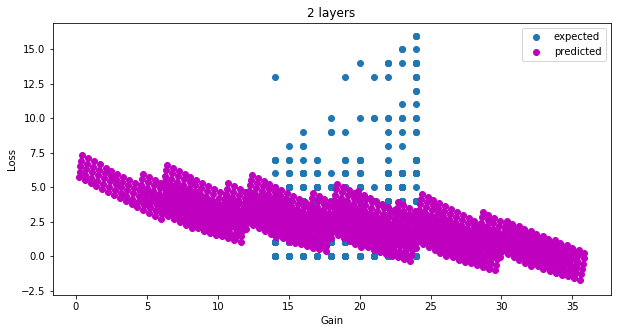

(array([12.16910008, 15.79710516, 10.20575624, 16.80860049, 13.67044345]), '=> 3.71 (+/- 4.78)')
(array([48.33958458, 30.31659414, 36.05357536, 27.99230474, 76.33754007]), '=> 6.62 (+/- 35.45)')
()


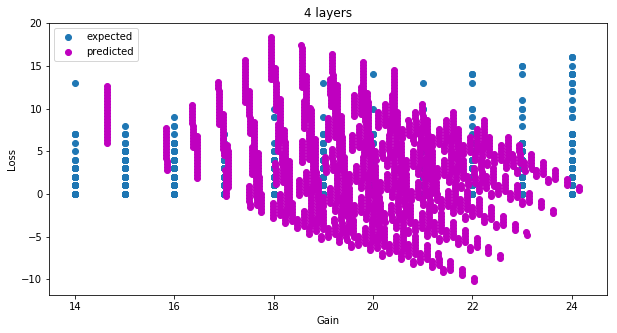

(array([13.53828982, 18.84213515, 10.72648793, 21.12476087, 15.44392109]), '=> 3.99 (+/- 7.40)')
(array([52.81865131, 39.02426245, 46.28041997, 38.22174366, 80.51872248]), '=> 7.17 (+/- 31.02)')
()


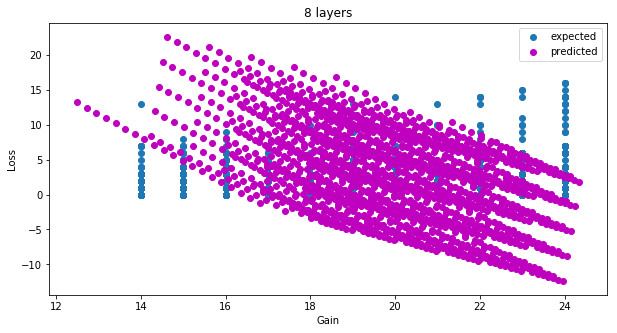

(array([11.67275952, 12.12613197,  9.44524194, 10.76745224, 10.73862301]), '=> 3.31 (+/- 1.84)')
(array([12.02462552,  5.15327022,  7.7250173 ,  3.86224962,  3.74502662]), '=> 2.55 (+/- 6.22)')
()


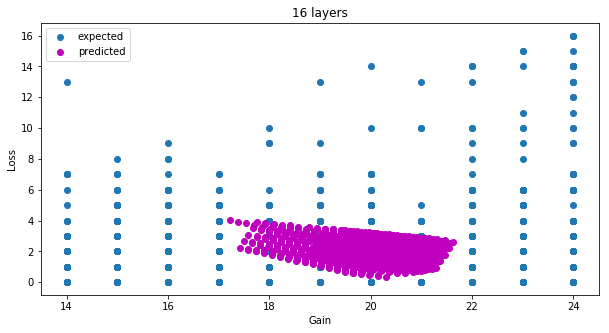

(array([12.19931892, 12.5968422 , 10.06775063, 11.80737394, 10.44470321]), '=> 3.38 (+/- 1.98)')
(array([13.72546249,  5.18348426,  8.3062841 ,  3.57288707,  3.70076937]), '=> 2.63 (+/- 7.63)')
()


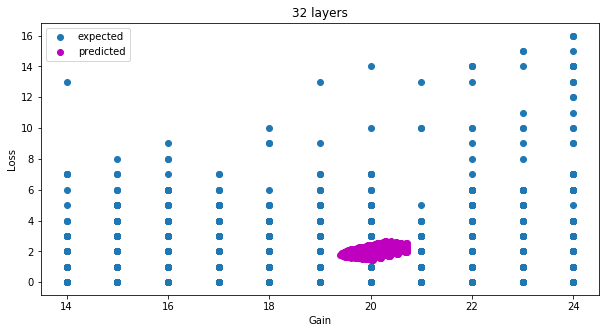

Done!


In [8]:
for layers in layerArray:
    regressor = setMLP(layers)
    trainModel(regressor)
    plotDistribution(regressor, layers)

print("Done!")

# Plotting graphs

([2, 4, 8, 16, 32], [88.23570191687836, 13.730201082522768, 15.935118971014205, 10.950041735375393, 11.423197781871455])


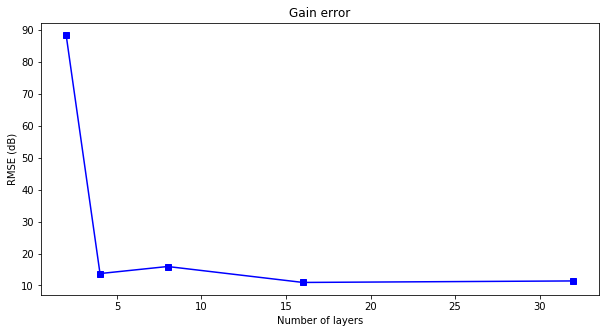

In [9]:
plotGainError()

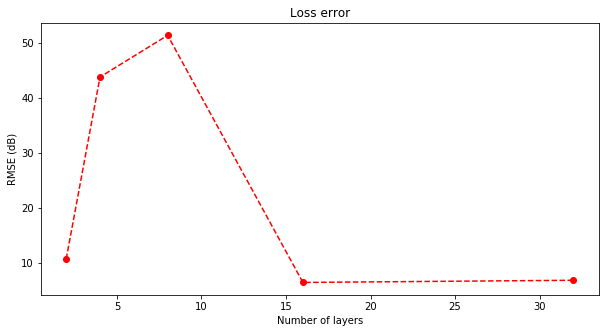

In [10]:
plotLossError()